In [1]:
import numpy as np 
import pandas as pd
import re

In [2]:
import json
with open('Dataset/intents.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])

In [3]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)
        
df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [4]:
df_responses = df.explode('responses')
all_patterns = ' '.join(df['patterns'])

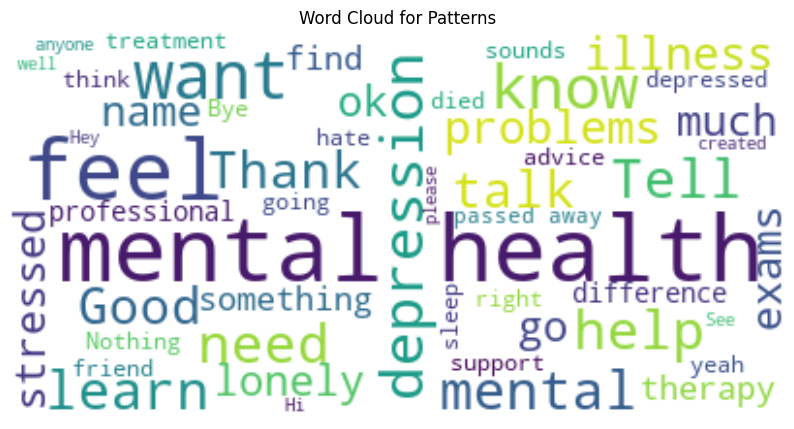

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
# Generate a word cloud image
wordcloud = WordCloud(background_color='white', max_words=50, contour_width=3, contour_color='steelblue').generate(all_patterns)

# Display the generated image:
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not show axes to keep it clean
plt.title('Word Cloud for Patterns')
plt.show()

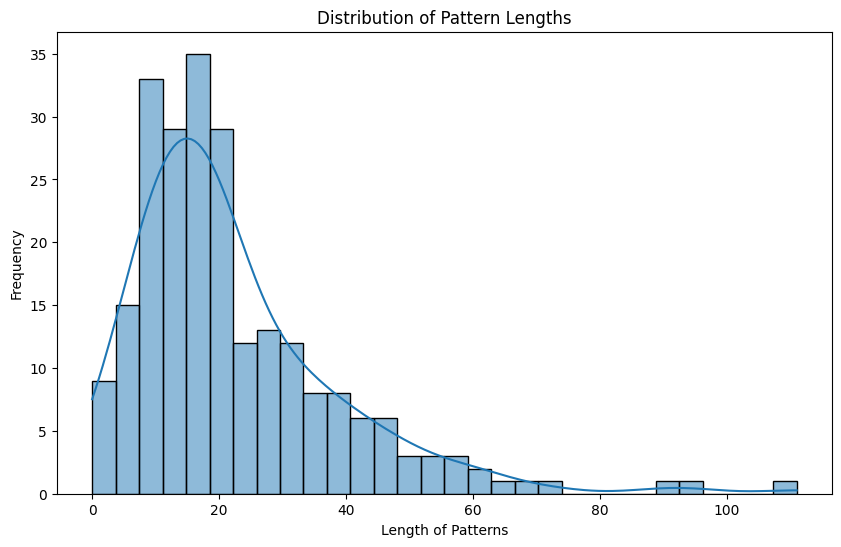

In [6]:
df['pattern_length'] = df['patterns'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['pattern_length'], bins=30, kde=True)
plt.title('Distribution of Pattern Lengths')
plt.xlabel('Length of Patterns')
plt.ylabel('Frequency')
plt.show()

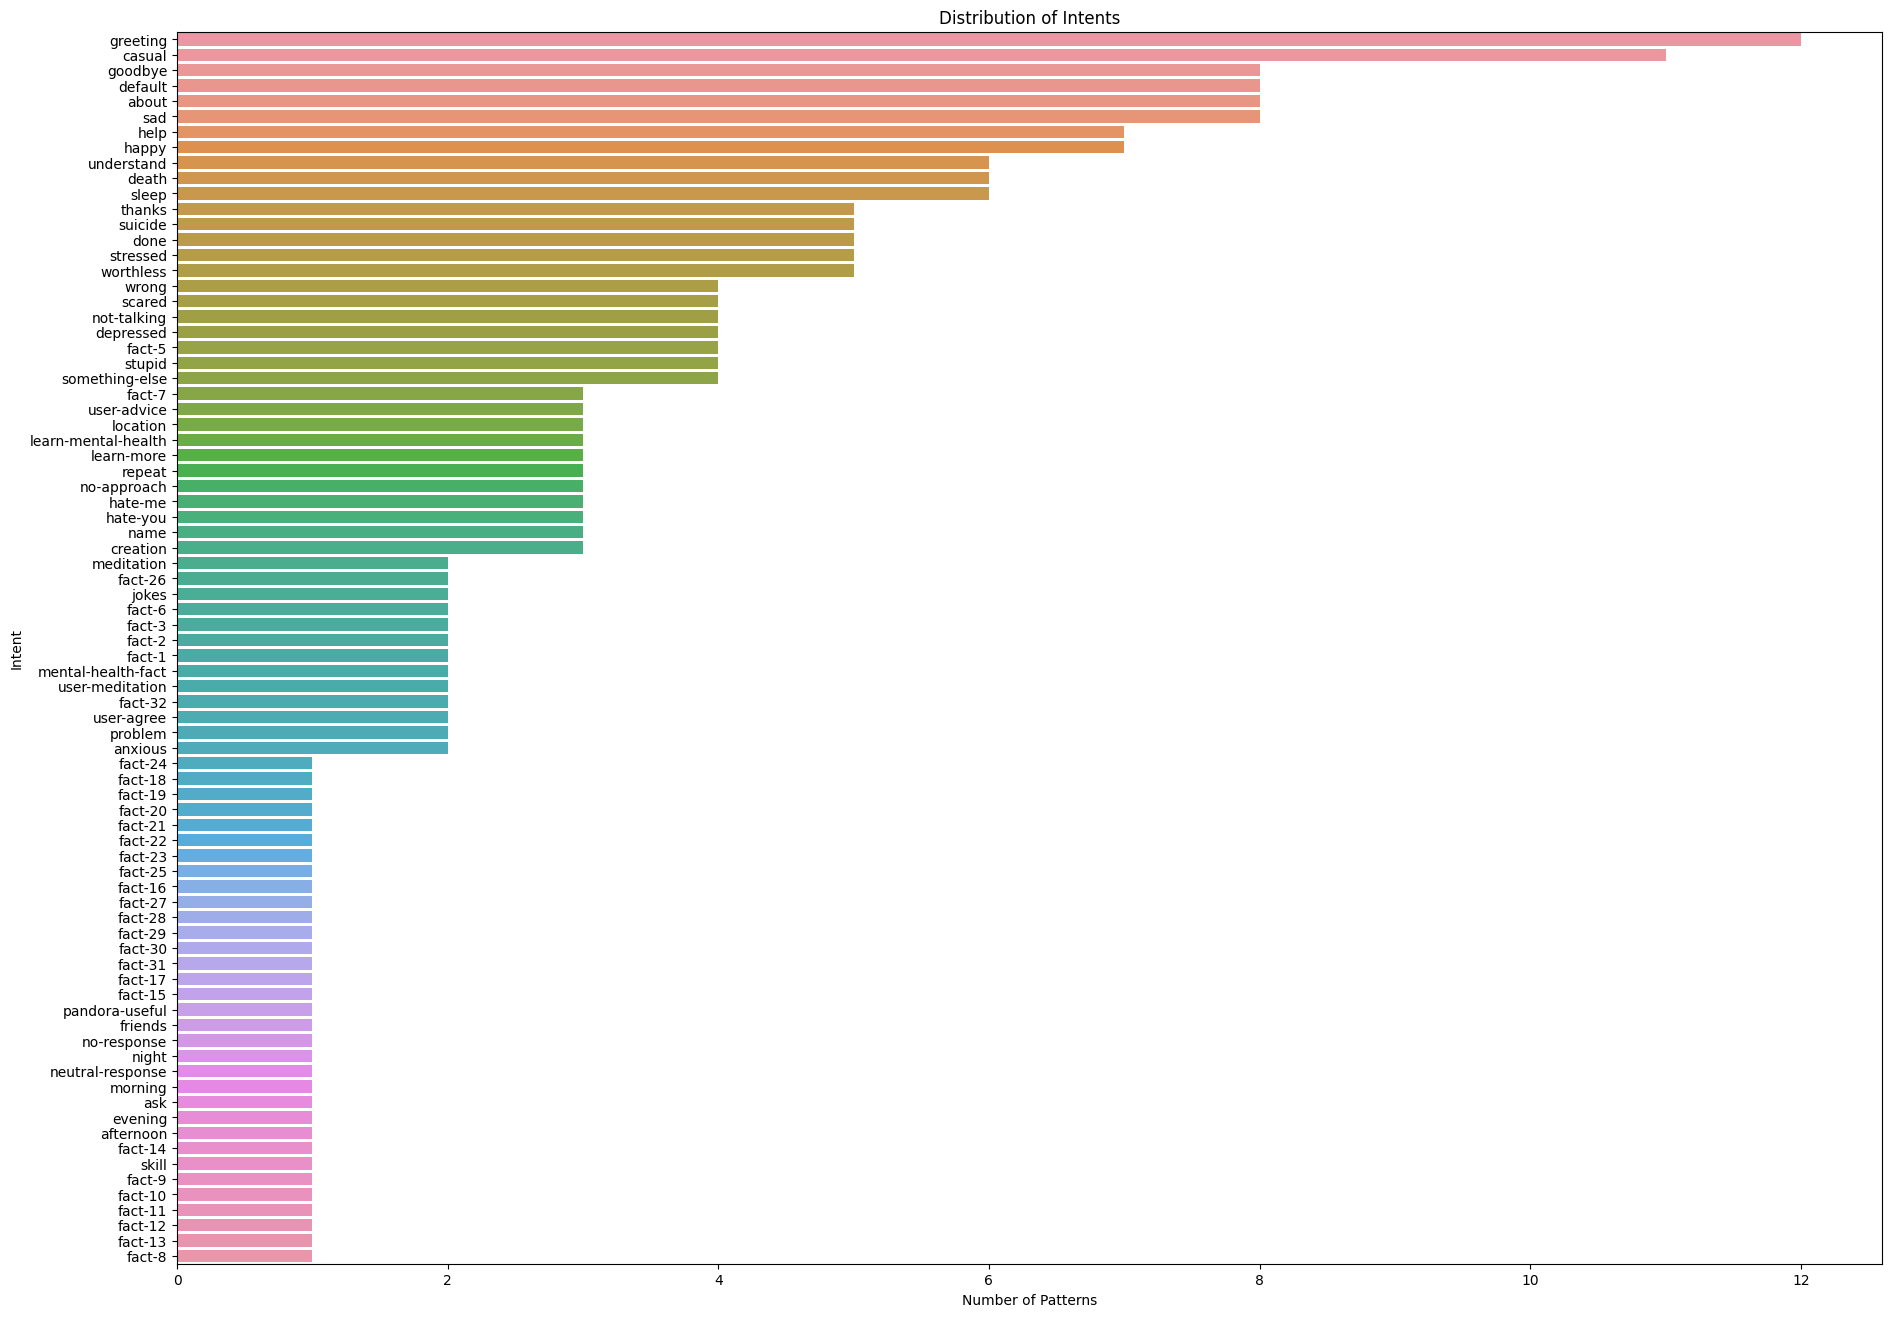

In [7]:
plt.figure(figsize=(22, 16))
sns.countplot(y='tag', data=df, order=df['tag'].value_counts().index)
plt.title('Distribution of Intents')
plt.xlabel('Number of Patterns')
plt.ylabel('Intent')
plt.show()

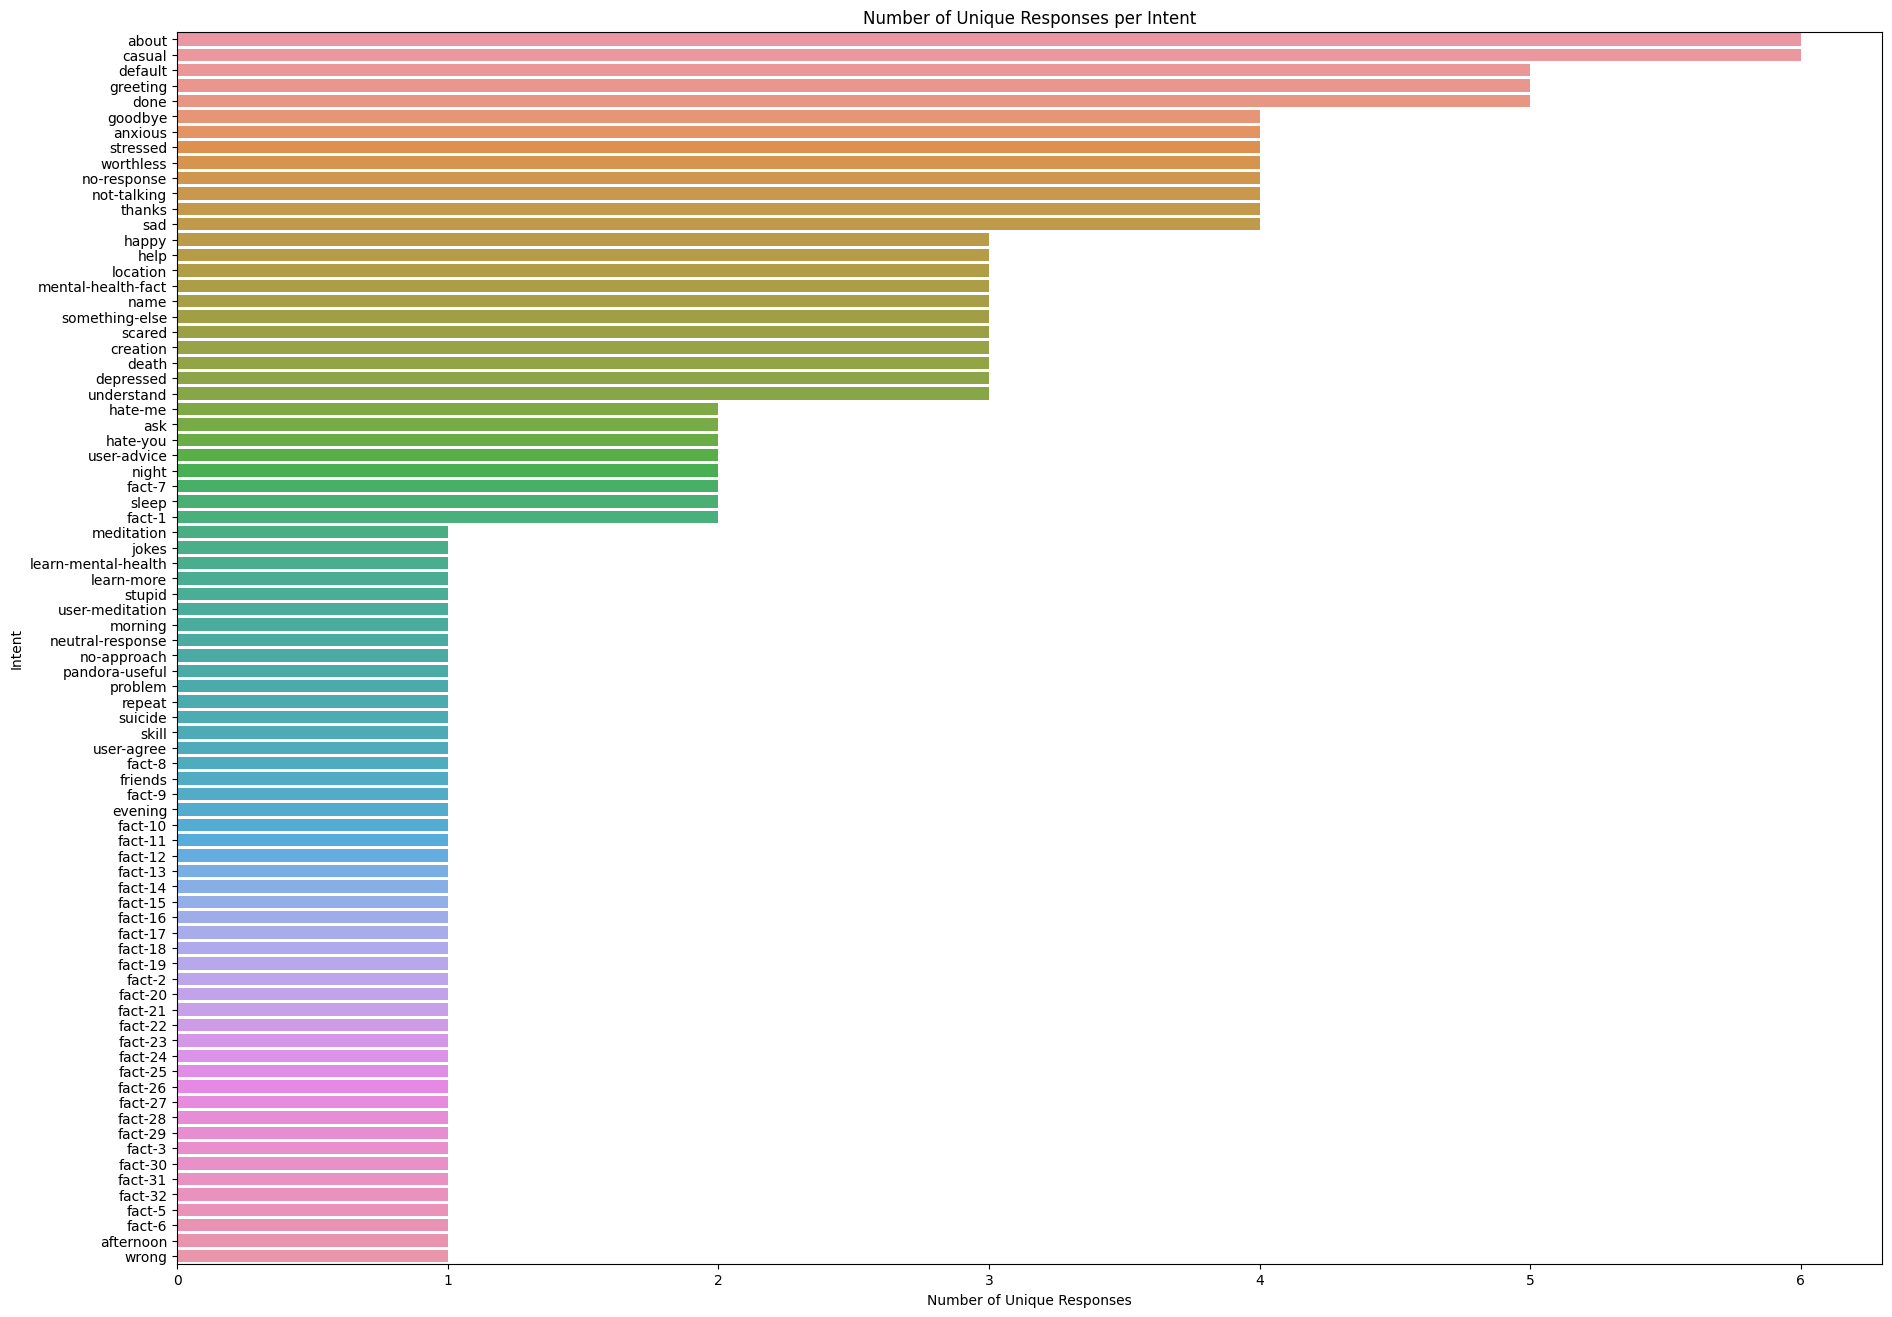

In [8]:
df_unique_responses = df_responses.groupby('tag')['responses'].nunique().reset_index(name='unique_responses')
plt.figure(figsize=(22, 16))
sns.barplot(x='unique_responses', y='tag', data=df_unique_responses.sort_values('unique_responses', ascending=False))
plt.title('Number of Unique Responses per Intent')
plt.xlabel('Number of Unique Responses')
plt.ylabel('Intent')
plt.show()

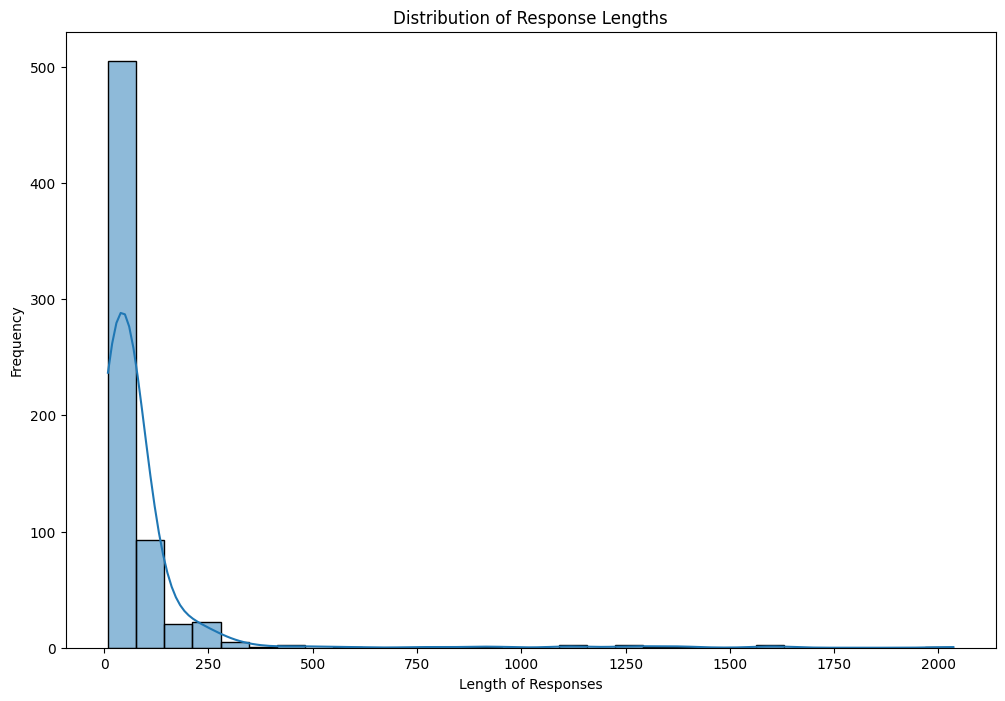

In [9]:
df_responses['response_length'] = df_responses['responses'].apply(len)
plt.figure(figsize=(12, 8))
sns.histplot(df_responses['response_length'], bins=30, kde=True)
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Responses')
plt.ylabel('Frequency')
plt.show()

In [10]:
def preprocess_text(s):
    s = re.sub('[^a-zA-Z\']', ' ', s)  # Keep only alphabets and apostrophes
    s = s.lower()  # Convert to lowercase
    s = s.split()  # Split into words
    s = " ".join(s)  # Rejoin words to ensure clean spacing
    return s

# Apply preprocessing to the patterns
df['patterns'] = df['patterns'].apply(preprocess_text)
df['tag'] = df['tag'].apply(preprocess_text)
df

,tag,patterns,responses,pattern_length
0,greeting,hi,[Hello there. Tell me how are you feeling toda...,2
1,greeting,hey,[Hello there. Tell me how are you feeling toda...,3
2,greeting,is anyone there,[Hello there. Tell me how are you feeling toda...,16
3,greeting,hi there,[Hello there. Tell me how are you feeling toda...,8
4,greeting,hello,[Hello there. Tell me how are you feeling toda...,5
...,...,...,...,...
227,fact,how do i know if i'm unwell,"[If your beliefs , thoughts , feelings or beha...",28
228,fact,how can i maintain social connections what if ...,"[A lot of people are alone right now, but we d...",61
229,fact,what's the difference between anxiety and stress,[Stress and anxiety are often used interchange...,49
230,fact,what's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap...",53


In [11]:
df['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no response', 'neutral response', 'about', 'skill',
       'creation', 'name', 'help', 'sad', 'stressed', 'worthless',
       'depressed', 'happy', 'casual', 'anxious', 'not talking', 'sleep',
       'scared', 'death', 'understand', 'done', 'suicide', 'hate you',
       'hate me', 'default', 'jokes', 'repeat', 'wrong', 'stupid',
       'location', 'something else', 'friends', 'ask', 'problem',
       'no approach', 'learn more', 'user agree', 'meditation',
       'user meditation', 'pandora useful', 'user advice',
       'learn mental health', 'mental health fact', 'fact'], dtype=object)

In [12]:
X = df['patterns']
y = df['tag']

In [13]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Tokenization and Encoding the Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128  # Max sequence length

def encode_texts(texts, max_len):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_labels = len(np.unique(y_encoded))

# Encode the patterns
input_ids, attention_masks = encode_texts(X, max_len)
labels = torch.tensor(y_encoded)

# Splitting the dataset into training and validation
dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
validation_dataloader = DataLoader(val_dataset, batch_size=16)

# Model and Optimization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5)

c:\Users\Andrés Arango\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Andrés Arango\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_len

In [14]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        # Convertir b_input_ids y b_labels a LongTensor
        b_input_ids = b_input_ids.long()
        b_labels = b_labels.long()
        
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.2f}")


Epoch 1, Average Training Loss: 3.92
Epoch 2, Average Training Loss: 3.67
Epoch 3, Average Training Loss: 3.48
Epoch 4, Average Training Loss: 3.22
Epoch 5, Average Training Loss: 2.98


In [15]:
def predict_intent(text):
    # Tokenize and encode the text for BERT
    encoded_dict = tokenizer.encode_plus(
        text,                      # Input text
        add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
        max_length=max_len,        # Pad or truncate to max length
        pad_to_max_length=True,    # Pad to max length
        return_attention_mask=True,# Construct attn. masks
        return_tensors='pt',       # Return pytorch tensors
    )
    
    # Extract input IDs and attention masks from the encoded representation
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    # No gradient calculation needed
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
    
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Use softmax to calculate probabilities
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()


    # Get the predicted label with the highest probability
    predicted_label_idx = np.argmax(probabilities, axis=1).flatten()
    
    # Decode the predicted label
    predicted_label = label_encoder.inverse_transform(predicted_label_idx)[0]
    
    return predicted_label, probabilities[0][predicted_label_idx]

# Example usage
test_message = "I feel anxious today"
predicted_intent = predict_intent(test_message)
print(f"Predicted Intent: {predicted_intent}")

Predicted Intent: ('fact', array([0.15247379], dtype=float32))


In [16]:
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")

('saved_model\\tokenizer_config.json',
 'saved_model\\special_tokens_map.json',
 'saved_model\\vocab.txt',
 'saved_model\\added_tokens.json')